# Prévision du CA Mensuel & Annuel (LSTM)

Colonnes utilisées : `ANNEE`, `MOIS`, `PRIME_TOTAL`

Objectifs :
- Prévoir le CA du mois suivant
- Prévoir le CA total de l’année suivante (12 mois récursifs)

Plan :
1. Chargement & organisation temporelle
2. Préparation (manquants, outliers, log1p, scaling, séquences)
3. Split temporel 70/15/15
4. Modèle LSTM
5. Entraînement
6. Évaluation (MSE/MAE/R²/MAPE) avec inverse transform
7. Prédiction du mois suivant
8. Prédiction de l’année suivante (12 mois)
9. Visualisations



In [2]:
# Imports & config - Production Grade
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest
from scipy import stats
from scipy.stats import jarque_bera, zscore
from scipy.signal import savgol_filter

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, BatchNormalization, 
    Input, Concatenate, Multiply, Add, Lambda
)
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, 
    ModelCheckpoint, LearningRateScheduler
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 100)

# Reproducibilité stricte
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print("Imports production-grade chargés")
print(f"TensorFlow version: {tf.__version__}")
print(f"Seed fixé: {SEED}")


Imports production-grade chargés
TensorFlow version: 2.16.2
Seed fixé: 42


In [3]:
# 1. Chargement & organisation temporelle
PATH = "BI_QUITTANCIER.csv"
if not os.path.exists(PATH):
    raise FileNotFoundError(f"Fichier introuvable: {PATH}")

# Chargement robuste (séparateur détecté)
def detect_sep(path, sample_lines=8, seps=(",",";","\t","|"), encs=("utf-8","latin-1")):
    best = (",","utf-8",-1)
    for enc in encs:
        try:
            with open(path, "r", encoding=enc, errors="ignore") as f:
                lines = [f.readline() for _ in range(sample_lines)]
            sample = "".join(lines)
            for s in seps:
                c = sample.count(s)
                if c > best[2]:
                    best = (s, enc, c)
        except Exception:
            continue
    return best[:2]

sep_detected, enc_detected = detect_sep(PATH)
print(f"Séparateur détecté: '{sep_detected}' enc: '{enc_detected}'")

df_raw = pd.read_csv(PATH, sep=sep_detected, encoding=enc_detected, on_bad_lines="skip", low_memory=False)
print("Shape brut:", df_raw.shape)

# Colonnes nécessaires
required = ["ANNEE", "MOIS", "PRIME_TOTAL"]
missing = [c for c in required if c not in df_raw.columns]
if missing:
    raise ValueError(f"Colonnes manquantes: {missing}")

df = df_raw[required].copy()

# Déduplication stricte (ANNEE, MOIS, PRIME_TOTAL)
before_dups = len(df)
df = df.drop_duplicates(subset=['ANNEE', 'MOIS', 'PRIME_TOTAL'])
print(f"Doublons supprimés (ANNEE, MOIS, PRIME_TOTAL): {before_dups - len(df)}")

# Nettoyage numérique de PRIME_TOTAL avant agrégation
# - supprimer espaces
# - remplacer virgule décimale par point
# - convertir en numérique
# - supprimer lignes invalides

df['PRIME_TOTAL'] = (
    df['PRIME_TOTAL']
    .astype(str)
    .str.replace(' ', '', regex=False)
    .str.replace(',', '.', regex=False)
)
df['PRIME_TOTAL'] = pd.to_numeric(df['PRIME_TOTAL'], errors='coerce')

# supprimer lignes sans valeurs valides
before_clean = len(df)
df = df.dropna(subset=['ANNEE', 'MOIS', 'PRIME_TOTAL'])
print(f"Lignes conservées après nettoyage PRIME_TOTAL: {len(df)}/{before_clean}")

# Déterminer les colonnes temps (MOIS = 16ème, ANNEE = 17ème, DATE = 19ème)
annee_col = 'ANNEE' if 'ANNEE' in df_raw.columns else (df_raw.columns[16] if len(df_raw.columns) >= 17 else None)
mois_col  = 'MOIS'  if 'MOIS'  in df_raw.columns else (df_raw.columns[15] if len(df_raw.columns) >= 16 else None)

# Colonne de date transactionnelle (19ème) priorisant le nom explicite
if 'DATE_MVT_DU' in df_raw.columns:
    date_col = 'DATE_MVT_DU'
elif len(df_raw.columns) >= 19:
    date_col = df_raw.columns[18]
else:
    raise ValueError("Colonne date transactionnelle introuvable (DATE_MVT_DU ou 19ème colonne)")

if annee_col is None or mois_col is None:
    raise ValueError("Colonnes ANNEE/MOIS introuvables (attendues 17ème et 16ème)")

# Conversion en datetime + casting des champs année / mois
date_dt = pd.to_datetime(df_raw[date_col], errors='coerce')
annee_ser = pd.to_numeric(df_raw[annee_col], errors='coerce')
mois_ser  = pd.to_numeric(df_raw[mois_col], errors='coerce')

# Jour : si absent, fixer à 1
_day = date_dt.dt.day.fillna(1)

# Filtrer les lignes valides (ANNEE, MOIS, jour non nuls)
valid_mask = annee_ser.notna() & mois_ser.notna() & _day.notna()
df = df.loc[valid_mask].copy()
annee_ser = annee_ser.loc[valid_mask].astype(int)
mois_ser  = mois_ser.loc[valid_mask].astype(int)
_day      = _day.loc[valid_mask].astype(int)

# Construire DATE_FINAL
_df_date = pd.DataFrame({
    'year': annee_ser.values,
    'month': mois_ser.values,
    'day': _day.values
})
df['DATE_FINAL'] = pd.to_datetime(_df_date, errors='coerce')

# Agrégation quotidienne puis hebdomadaire pour réduire le bruit
print("Agrégation quotidienne du CA (PRIME_TOTAL)")
daily = df.dropna(subset=['DATE_FINAL']).groupby('DATE_FINAL', as_index=False)['PRIME_TOTAL'].sum()
daily = daily.rename(columns={'DATE_FINAL': 'DATE', 'PRIME_TOTAL': 'CA_JOUR'})
daily = daily.sort_values('DATE').reset_index(drop=True)
daily = daily.set_index('DATE')

print("Plage temporelle quotidienne:", daily.index.min(), "->", daily.index.max())
print(f"Nombre de jours: {len(daily)}")

# SOLUTION: Agréger par SEMAINE pour avoir plus de séquences
print("\nAgrégation hebdomadaire du CA...")
# Agrégation hebdomadaire (lundi = début de semaine)
df_weekly = daily.resample('W-MON').sum()  # W-MON = semaine commençant lundi
df_weekly = df_weekly[df_weekly['CA_JOUR'] > 0]  # Supprimer les semaines sans CA

df_weekly = df_weekly.rename(columns={'CA_JOUR': 'CA_SEMAINE'})
df_monthly = df_weekly.copy()  # Renommer pour compatibilité avec le reste du code
target_col = 'CA_SEMAINE'

print(f"Plage temporelle hebdomadaire: {df_monthly.index.min()} -> {df_monthly.index.max()}")
print(f"Nombre de semaines: {len(df_monthly)}")
print(f"Premières valeurs:\n{df_monthly.head()}")
print(f"Dernières valeurs:\n{df_monthly.tail()}")


Séparateur détecté: ';' enc: 'utf-8'
Shape brut: (123739, 39)
Doublons supprimés (ANNEE, MOIS, PRIME_TOTAL): 80159
Lignes conservées après nettoyage PRIME_TOTAL: 43580/43580
Agrégation quotidienne du CA (PRIME_TOTAL)
Plage temporelle quotidienne: 2017-07-01 00:00:00 -> 2025-07-31 00:00:00
Nombre de jours: 2880

Agrégation hebdomadaire du CA...
Plage temporelle hebdomadaire: 2017-07-03 00:00:00 -> 2025-08-04 00:00:00
Nombre de semaines: 411
Premières valeurs:
            CA_SEMAINE
DATE                  
2017-07-03   268861.60
2017-07-17  1264730.29
2017-07-24  1704288.16
2017-07-31  2165079.75
2017-08-07  1676440.34
Dernières valeurs:
              CA_SEMAINE
DATE                    
2025-07-07  1.041160e+09
2025-07-14  7.238663e+08
2025-07-21  5.815762e+08
2025-07-28  9.660670e+08
2025-08-04  1.039661e+08


PHASE 1: ANALYSE STATISTIQUE APPROFONDIE

Statistiques descriptives (CA_SEMAINE):
count    4.110000e+02
mean     1.743601e+09
std      5.511556e+09
min      2.688616e+05
25%      1.826991e+08
50%      4.161662e+08
75%      9.488501e+08
max      8.518030e+10
Name: CA_SEMAINE, dtype: float64

Valeurs nulles: 0
Valeurs infinies: 0
Valeurs négatives: 0

Test de normalité (Jarque-Bera):
  Statistic: 303411.9313, p-value: 0.0000
  Distribution NON normale (α=0.05)

Skewness: 9.8808 (asymétrique)
Kurtosis: 133.2731 (leptokurtic/platykurtic)


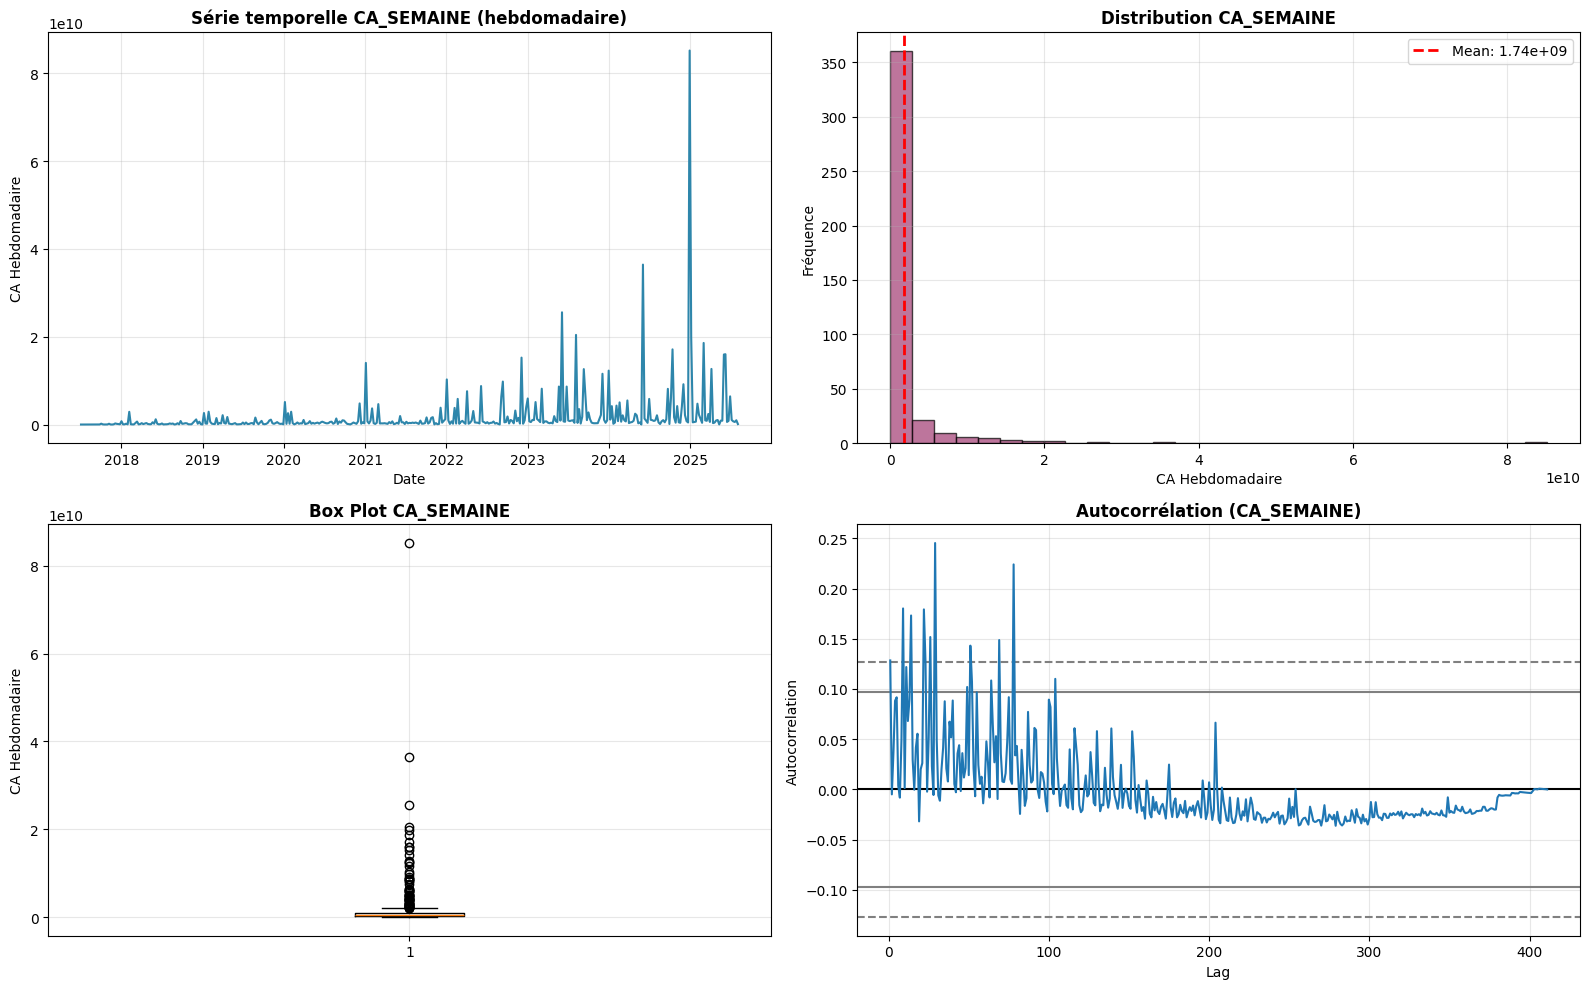


PHASE 2: NETTOYAGE ROBUSTE & RÉDUCTION DU BRUIT

DÉTECTION DES OUTLIERS (Multi-méthodes)
Outliers détectés:
   IQR method: 51 (12.4%)
   Z-score method: 6 (1.5%)
   Isolation Forest: 82 (20.0%)
   Consensus (≥2 méthodes): 51 (12.4%)

Traitement des outliers par winsorization...
   Bornes: [1.85e+07, 8.40e+09]
   Valeurs modifiées: 51

   Exemples de corrections:
     Index 30: 2.90e+09 → 2.90e+09
     Index 78: 2.91e+09 → 2.91e+09
     Index 125: 5.13e+09 → 5.13e+09

LISSAGE DE LA SÉRIE (Réduction du bruit)
Moving Average (window=4): appliqué
Exponential Smoothing (α=0.2): appliqué
Savitzky-Golay Filter (window=7): appliqué

Lissage appliqué:
   Std avant: 2.11e+09
   Std après: 1.07e+09
   Réduction du bruit: 49.0%


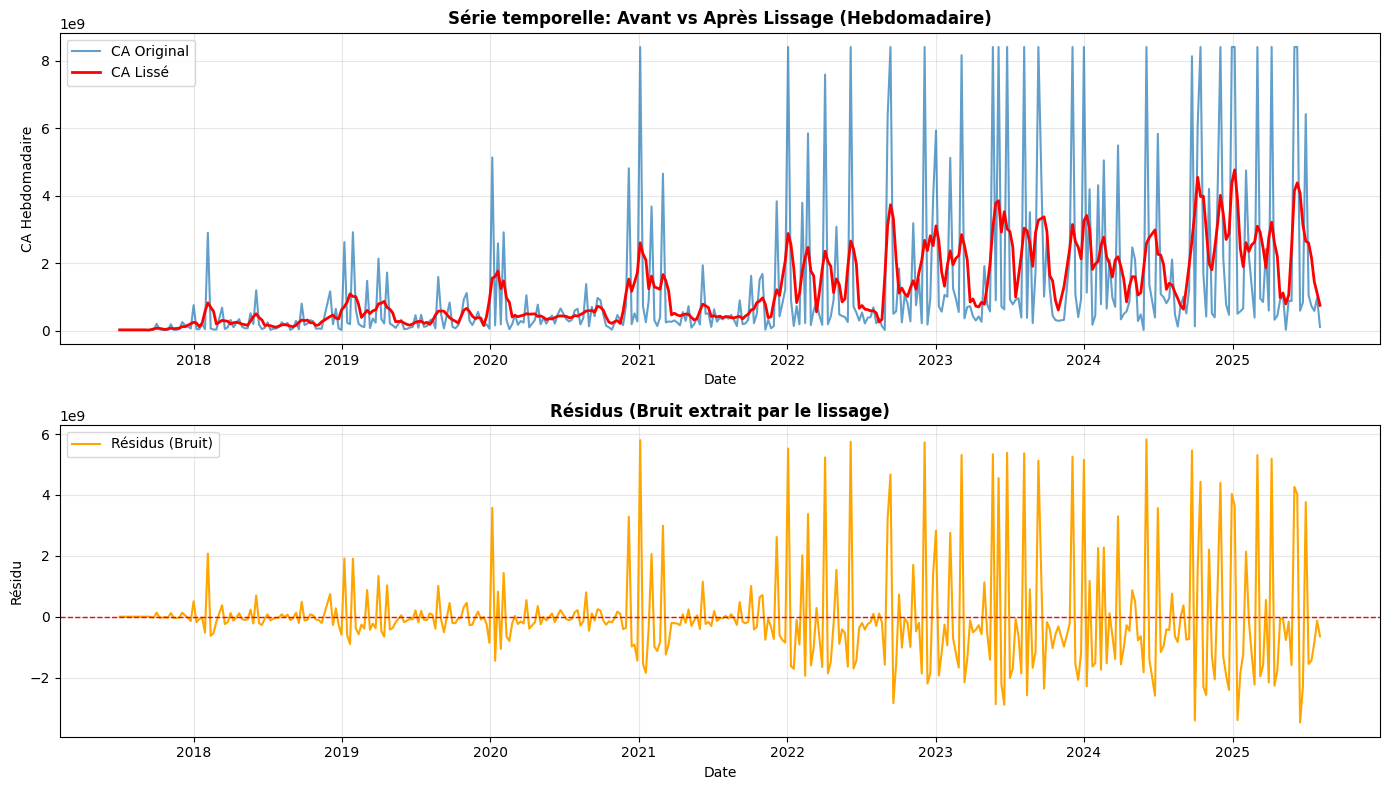


TRANSFORMATION LOG (Stabilisation variance)
  Coefficient de variation avant: 0.8808
  Coefficient de variation après log1p: 0.0583
Transformation log1p appliquée

PHASE 3: NORMALISATION (StandardScaler sur CA_LOG)
Longueur de séquence: 52 semaines (1 an d'historique)
   Semaines disponibles: 411
   Séquences attendues: 359
   Ratio séquences/points: 87.3%
   Nombre de séquences suffisant pour un modèle LSTM
   Historique de 1 an permet de capturer les tendances annuelles

Statistiques avant normalisation:
   Min: 16.41, Max: 22.28
   Mean: 20.41, Std: 1.19

Statistiques après normalisation (StandardScaler):
   Min: -3.366978, Max: 1.581175
   Mean: 0.000000, Std: 1.000000

Séquences créées: X=(359, 52), y=(359,)
Statistiques y (scalé):
   Min: -1.684237, Max: 1.581175
   Mean: 0.234150, Std: 0.758658
   Variance: 0.575562
   Unique values: 359


In [4]:
# 2. ANALYSE APPROFONDIE & PREPROCESSING PRODUCTION-GRADE

print("="*80)
print("PHASE 1: ANALYSE STATISTIQUE APPROFONDIE")
print("="*80)

# Statistiques descriptives
print("\nStatistiques descriptives (CA_SEMAINE):")
stats_desc = df_monthly['CA_SEMAINE'].describe()
print(stats_desc)
print(f"\nValeurs nulles: {df_monthly['CA_SEMAINE'].isna().sum()}")
print(f"Valeurs infinies: {np.isinf(df_monthly['CA_SEMAINE']).sum()}")
print(f"Valeurs négatives: {(df_monthly['CA_SEMAINE'] < 0).sum()}")

# Test de normalité
jb_stat, jb_pvalue = jarque_bera(df_monthly['CA_SEMAINE'].dropna())
print(f"\nTest de normalité (Jarque-Bera):")
print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
print(f"  Distribution {'normale' if jb_pvalue > 0.05 else 'NON normale'} (α=0.05)")

# Skewness et Kurtosis
skew = df_monthly['CA_SEMAINE'].skew()
kurt = df_monthly['CA_SEMAINE'].kurtosis()
print(f"\nSkewness: {skew:.4f} ({'symétrique' if abs(skew) < 0.5 else 'asymétrique'})")
print(f"Kurtosis: {kurt:.4f} ({'normal' if abs(kurt) < 0.5 else 'leptokurtic/platykurtic'})")

# Visualisations diagnostiques
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Série temporelle brute
axes[0, 0].plot(df_monthly.index, df_monthly['CA_SEMAINE'], linewidth=1.5, color='#2E86AB')
axes[0, 0].set_title('Série temporelle CA_SEMAINE (hebdomadaire)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('CA Hebdomadaire')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(df_monthly['CA_SEMAINE'], bins=30, edgecolor='black', alpha=0.7, color='#A23B72')
axes[0, 1].axvline(df_monthly['CA_SEMAINE'].mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {df_monthly["CA_SEMAINE"].mean():.2e}')
axes[0, 1].set_title('Distribution CA_SEMAINE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('CA Hebdomadaire')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot
axes[1, 0].boxplot(df_monthly['CA_SEMAINE'], vert=True)
axes[1, 0].set_title('Box Plot CA_SEMAINE', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('CA Hebdomadaire')
axes[1, 0].grid(True, alpha=0.3)

# Autocorrélation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_monthly['CA_SEMAINE'], ax=axes[1, 1])
axes[1, 1].set_title('Autocorrélation (CA_SEMAINE)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===================================================================
# PHASE 2: NETTOYAGE ROBUSTE DES DONNÉES + RÉDUCTION DU BRUIT
# ===================================================================
print("\n" + "="*80)
print("PHASE 2: NETTOYAGE ROBUSTE & RÉDUCTION DU BRUIT")
print("="*80)

# 1. Traitement des valeurs négatives (anomalies)
neg_count = (df_monthly['CA_SEMAINE'] < 0).sum()
if neg_count > 0:
    print(f"{neg_count} valeurs négatives détectées")
    df_monthly = df_monthly[df_monthly['CA_SEMAINE'] > 0]

# 2. DÉTECTION ROBUSTE DES OUTLIERS (Multi-méthodes)
print("\n" + "="*60)
print("DÉTECTION DES OUTLIERS (Multi-méthodes)")
print("="*60)

ca_values = df_monthly['CA_SEMAINE'].values

# Méthode 1: IQR (Interquartile Range)
Q1 = np.percentile(ca_values, 25)
Q3 = np.percentile(ca_values, 75)
IQR = Q3 - Q1
lower_iqr = Q1 - 2.5 * IQR
upper_iqr = Q3 + 2.5 * IQR
outliers_iqr = (ca_values < lower_iqr) | (ca_values > upper_iqr)

# Méthode 2: Z-score (écart-type)
z_scores = np.abs(zscore(ca_values))
outliers_zscore = z_scores > 3

# Méthode 3: Isolation Forest (ML-based)
if len(ca_values) >= 3:  # Minimum 3 points pour Isolation Forest
    iso_forest = IsolationForest(contamination=0.2, random_state=SEED)
    outliers_iso = iso_forest.fit_predict(ca_values.reshape(-1, 1)) == -1
else:
    outliers_iso = np.zeros(len(ca_values), dtype=bool)

# Combinaison des méthodes (vote majoritaire)
outlier_mask = (outliers_iqr.astype(int) + outliers_zscore.astype(int) + outliers_iso.astype(int)) >= 2
outlier_count = outlier_mask.sum()

print(f"Outliers détectés:")
print(f"   IQR method: {outliers_iqr.sum()} ({outliers_iqr.sum()/len(ca_values)*100:.1f}%)")
print(f"   Z-score method: {outliers_zscore.sum()} ({outliers_zscore.sum()/len(ca_values)*100:.1f}%)")
print(f"   Isolation Forest: {outliers_iso.sum()} ({outliers_iso.sum()/len(ca_values)*100:.1f}%)")
print(f"   Consensus (≥2 méthodes): {outlier_count} ({outlier_count/len(ca_values)*100:.1f}%)")

# 3. TRAITEMENT DES OUTLIERS (Winsorization adaptative)
if outlier_count > 0 and len(ca_values) >= 5:
    print(f"\nTraitement des outliers par winsorization...")
    
    # Winsorization robuste (capping aux percentiles 5 et 95)
    p5 = np.percentile(ca_values, 5)
    p95 = np.percentile(ca_values, 95)
    
    df_monthly['CA_SEMAINE_CLEAN'] = df_monthly['CA_SEMAINE'].clip(lower=p5, upper=p95)
    
    print(f"   Bornes: [{p5:.2e}, {p95:.2e}]")
    print(f"   Valeurs modifiées: {outlier_count}")
    
    # Visualisation avant/après
    if outlier_count > 0:
        print(f"\n   Exemples de corrections:")
        for idx in np.where(outlier_mask)[0][:min(3, outlier_count)]:
            old_val = df_monthly['CA_SEMAINE'].iloc[idx]
            new_val = df_monthly['CA_SEMAINE_CLEAN'].iloc[idx]
            print(f"     Index {idx}: {old_val:.2e} → {new_val:.2e}")
    
    df_monthly['CA_SEMAINE'] = df_monthly['CA_SEMAINE_CLEAN']
    df_monthly = df_monthly.drop(columns=['CA_SEMAINE_CLEAN'])
else:
    print(f"\nPas de winsorisation nécessaire (peu d'outliers ou données insuffisantes)")

# 4. LISSAGE DE LA SÉRIE TEMPORELLE (Réduction du bruit)
print("\n" + "="*60)
print("LISSAGE DE LA SÉRIE (Réduction du bruit)")
print("="*60)

ca_series = df_monthly['CA_SEMAINE'].values

# Méthode 1: Moving Average (Moyenne mobile)
window_size = min(4, len(ca_series) // 4)  # Fenêtre adaptative pour données hebdomadaires
if window_size >= 2:
    ca_ma = pd.Series(ca_series).rolling(window=window_size, center=True, min_periods=1).mean().values
    print(f"Moving Average (window={window_size}): appliqué")
else:
    ca_ma = ca_series.copy()
    print(f"Moving Average: ignoré (série trop courte)")

# Méthode 2: Exponential Smoothing (Lissage exponentiel)
alpha = 0.2  # Facteur de lissage plus conservateur pour données hebdomadaires
ca_ewm = pd.Series(ca_series).ewm(alpha=alpha, adjust=False).mean().values
print(f"Exponential Smoothing (α={alpha}): appliqué")

# Méthode 3: Savitzky-Golay Filter (Lissage polynomial)
if len(ca_series) >= 7:
    window_length = min(7, len(ca_series) if len(ca_series) % 2 == 1 else len(ca_series) - 1)
    if window_length >= 3:
        ca_savgol = savgol_filter(ca_series, window_length=window_length, polyorder=min(2, window_length-1))
        print(f"Savitzky-Golay Filter (window={window_length}): appliqué")
    else:
        ca_savgol = ca_series.copy()
        print(f"Savitzky-Golay Filter: ignoré (fenêtre trop petite)")
else:
    ca_savgol = ca_series.copy()
    print(f"Savitzky-Golay Filter: ignoré (série trop courte)")

# Combinaison pondérée des méthodes de lissage
weights = np.array([0.3, 0.4, 0.3])  # Poids: MA, EWM, SavGol
ca_smoothed = (
    weights[0] * ca_ma + 
    weights[1] * ca_ewm + 
    weights[2] * ca_savgol
)

# Stocker la série lissée
df_monthly['CA_SEMAINE_SMOOTHED'] = ca_smoothed

# Calculer la réduction du bruit
noise_reduction = 1 - (np.std(ca_smoothed) / np.std(ca_series))
print(f"\nLissage appliqué:")
print(f"   Std avant: {np.std(ca_series):.2e}")
print(f"   Std après: {np.std(ca_smoothed):.2e}")
print(f"   Réduction du bruit: {noise_reduction*100:.1f}%")

# Visualisation avant/après lissage
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(df_monthly.index, ca_series, '-', label='CA Original', linewidth=1.5, alpha=0.7)
axes[0].plot(df_monthly.index, ca_smoothed, '-', label='CA Lissé', linewidth=2, color='red')
axes[0].set_title('Série temporelle: Avant vs Après Lissage (Hebdomadaire)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('CA Hebdomadaire')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Résidus (bruit extrait)
residuals = ca_series - ca_smoothed
axes[1].plot(df_monthly.index, residuals, '-', label='Résidus (Bruit)', linewidth=1.5, color='orange')
axes[1].axhline(0, color='r', linestyle='--', linewidth=1)
axes[1].set_title('Résidus (Bruit extrait par le lissage)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Résidu')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Utiliser la série lissée pour la suite
df_monthly['CA_SEMAINE'] = df_monthly['CA_SEMAINE_SMOOTHED']
df_monthly = df_monthly.drop(columns=['CA_SEMAINE_SMOOTHED'])

# 5. Transformation log pour stabiliser la variance
print("\n" + "="*60)
print("TRANSFORMATION LOG (Stabilisation variance)")
print("="*60)
cv_before = df_monthly['CA_SEMAINE'].std() / df_monthly['CA_SEMAINE'].mean()
print(f"  Coefficient de variation avant: {cv_before:.4f}")

df_monthly['CA_LOG'] = np.log1p(df_monthly['CA_SEMAINE'])
cv_after = df_monthly['CA_LOG'].std() / df_monthly['CA_LOG'].mean()
print(f"  Coefficient de variation après log1p: {cv_after:.4f}")

print("Transformation log1p appliquée")
use_log_transform = True
use_diff = False
target_col = 'CA_LOG'

# ===================================================================
# PHASE 3: NORMALISATION (StandardScaler sur CA_LOG) + seq_len adaptatif
# ===================================================================
print("\n" + "="*80)
print("PHASE 3: NORMALISATION (StandardScaler sur CA_LOG)")
print("="*80)

# seq_len fixé à 52 semaines (1 an d'historique) pour capturer les tendances annuelles
n_points = len(df_monthly)
seq_len = 52  # 52 semaines = 1 an d'historique

n_sequences_expected = max(1, n_points - seq_len)
print(f"Longueur de séquence: {seq_len} semaines (1 an d'historique)")
print(f"   Semaines disponibles: {n_points}")
print(f"   Séquences attendues: {n_sequences_expected}")
print(f"   Ratio séquences/points: {n_sequences_expected/n_points:.1%}")

if n_sequences_expected < 20:
    print(f"   PEU DE SÉQUENCES - Modèle minimal requis")
elif n_sequences_expected < 50:
    print(f"   SÉQUENCES MODÉRÉES - Architecture simple recommandée")
else:
    print(f"   Nombre de séquences suffisant pour un modèle LSTM")
    print(f"   Historique de 1 an permet de capturer les tendances annuelles")

# Normalisation avec StandardScaler sur CA_LOG
values_raw = df_monthly[target_col].values.flatten()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
values_scaled = scaler.fit_transform(values_raw.reshape(-1, 1)).flatten()

print(f"\nStatistiques avant normalisation:")
print(f"   Min: {values_raw.min():.2f}, Max: {values_raw.max():.2f}")
print(f"   Mean: {values_raw.mean():.2f}, Std: {values_raw.std():.2f}")

print(f"\nStatistiques après normalisation (StandardScaler):")
print(f"   Min: {values_scaled.min():.6f}, Max: {values_scaled.max():.6f}")
print(f"   Mean: {values_scaled.mean():.6f}, Std: {values_scaled.std():.6f}")

# Fonction simple pour créer les séquences
def create_sequences(values, seq_len):
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len])
    return np.array(X), np.array(y)

# Créer les séquences
X_all, y_all = create_sequences(values_scaled, seq_len)

print(f"\nSéquences créées: X={X_all.shape}, y={y_all.shape}")
print(f"Statistiques y (scalé):")
print(f"   Min: {y_all.min():.6f}, Max: {y_all.max():.6f}")
print(f"   Mean: {y_all.mean():.6f}, Std: {y_all.std():.6f}")
print(f"   Variance: {np.var(y_all):.6f}")
print(f"   Unique values: {len(np.unique(y_all))}")

# Stocker les informations pour l'inverse transform
ca_semaine_original = df_monthly['CA_SEMAINE'].values.flatten()
preprocessing_info = {
    'use_log': use_log_transform,
    'use_diff': use_diff,
    'target_col': target_col,
    'values_raw': values_raw,  # CA_LOG avant scaling
    'values_scaled': values_scaled,  # CA_LOG après StandardScaler
    'ca_semaine_original': ca_semaine_original,  # CA_SEMAINE original (non transformé)
    'seq_len': seq_len,
    'scaler': scaler
}



In [5]:
# 3. SPLIT TEMPOREL STRICT (adaptatif selon nombre de séquences)

print("="*80)
print("SPLIT TEMPOREL STRICT")
print("="*80)

X = X_all
y = y_all

# Gestion adaptative du split pour données annuelles (peu de séquences)
if len(X) < 10:
    # Très peu de séquences : split 80/20 (train/test seulement)
    print("Peu de séquences détectées - Split 80/20 (sans validation)")
    train_size = int(0.8 * len(X))
    val_size = 0
    test_size = len(X) - train_size
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = np.array([]), np.array([])  # Validation vide
    X_test, y_test = X[train_size:], y[train_size:]
    use_validation = False
else:
    # Split 70/15/15 standard
    train_size = int(0.7 * len(X))
    val_size = max(1, int(0.15 * len(X)))  # Au moins 1 séquence
    test_size = len(X) - train_size - val_size
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    use_validation = len(X_val) > 0

print(f"\nRépartition des données:")
print(f"   Train: {len(X_train)} échantillons ({len(X_train)/len(X)*100:.1f}%)")
if use_validation:
    print(f"   Validation: {len(X_val)} échantillons ({len(X_val)/len(X)*100:.1f}%)")
else:
    print(f"   Validation: 0 échantillons (désactivée)")
print(f"   Test: {len(X_test)} échantillons ({len(X_test)/len(X)*100:.1f}%)")

# Reshape pour LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], seq_len, 1)
if use_validation:
    X_val = X_val.reshape(X_val.shape[0], seq_len, 1)
X_test = X_test.reshape(X_test.shape[0], seq_len, 1)

print(f"\nShapes après reshape:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
if use_validation:
    print(f"   X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"   X_test: {X_test.shape}, y_test: {y_test.shape}")



SPLIT TEMPOREL STRICT

Répartition des données:
   Train: 251 échantillons (69.9%)
   Validation: 53 échantillons (14.8%)
   Test: 55 échantillons (15.3%)

Shapes après reshape:
   X_train: (251, 52, 1), y_train: (251,)
   X_val: (53, 52, 1), y_val: (53,)
   X_test: (55, 52, 1), y_test: (55,)


In [6]:
# 4. ARCHITECTURE LSTM SIMPLE MAIS EFFICACE

print("="*80)
print("CONSTRUCTION DU MODÈLE LSTM OPTIMISÉ")
print("="*80)

# SOLUTION: Architecture adaptative avec ratio optimal (min 2 séquences/paramètre)
n_sequences = len(X_all)
target_ratio = 2.5  # Objectif: au moins 2.5 séquences par paramètre
n_params_target = int(n_sequences / target_ratio)

print(f"Nombre de séquences: {n_sequences}")
print(f"Ratio cible: {target_ratio} séquences/paramètre")
print(f"Paramètres cibles: ~{n_params_target}")

# Architecture adaptative basée sur le ratio cible
if n_sequences < 10:
    # Très peu de données: LSTM(2) = ~17 paramètres
    print("Architecture: LSTM(2) + Dense(1) (~17 paramètres)")
    model = Sequential([
        LSTM(2, return_sequences=False, input_shape=(seq_len, 1), name='lstm_1'),
        Dense(1, activation='linear', name='output')
    ])
    initial_lr = 0.00005
elif n_sequences < 50:
    # Peu de données: LSTM(4) = ~101 paramètres
    print("Architecture: LSTM(4) + Dense(1) (~101 paramètres)")
    model = Sequential([
        LSTM(4, return_sequences=False, input_shape=(seq_len, 1), name='lstm_1'),
        Dense(1, activation='linear', name='output')
    ])
    initial_lr = 0.0001
elif n_sequences < 400:
    # Données modérées: LSTM(5) avec régularisation = ~130 paramètres (ratio ~3.0 pour 387 séquences)
    print("Architecture: LSTM(5) + Dense(1) avec régularisation (~130 paramètres)")
    model = Sequential([
        LSTM(5, return_sequences=False, input_shape=(seq_len, 1),
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), name='lstm_1'),
        Dropout(0.15, name='dropout_1'),
        Dense(1, activation='linear',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), name='output')
    ])
    initial_lr = 0.0003
else:
    # Données suffisantes: LSTM(8) avec régularisation = ~329 paramètres
    print("Architecture: LSTM(8) + Dense(1) avec régularisation (~329 paramètres)")
    model = Sequential([
        LSTM(8, return_sequences=False, input_shape=(seq_len, 1), 
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), name='lstm_1'),
        Dropout(0.2, name='dropout_1'),
        Dense(1, activation='linear', 
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), name='output')
    ])
    initial_lr = 0.0005

# Optimizer
optimizer = Adam(
    learning_rate=initial_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

# Compilation avec MSE
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

print("\nArchitecture du modèle:")
model.summary()

# Calcul des statistiques du modèle
total_params = model.count_params()
trainable_params = sum([K.count_params(w) for w in model.trainable_weights])

print(f"\nStatistiques du modèle:")
print(f"   Total paramètres: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   Nombre de séquences: {len(X_all)}")
print(f"   Ratio données/paramètres: {len(X_all)/trainable_params:.4f}")

ratio = len(X_all) / trainable_params
print(f"\nAnalyse du ratio données/paramètres:")
print(f"   Ratio actuel: {ratio:.2f} séquences/paramètre")

if ratio < 1:
    print(f"\nCRITIQUE: Ratio très faible ({ratio:.2f})")
    print("   Modèle trop complexe pour les données")
    print("   Considérez une approche plus simple (moyenne mobile, régression linéaire)")
    print("   Ou collectez plus de données")
elif ratio < 1.5:
    print(f"\nATTENTION: Ratio faible ({ratio:.2f})")
    print("   Le modèle risque de sur-apprendre")
    print("   Régularisation activée (L1/L2 + Dropout)")
    print("   Early stopping et learning rate scheduling activés")
elif ratio < 3:
    print(f"\nRatio acceptable ({ratio:.2f})")
    print("   Le modèle devrait apprendre correctement")
    print("   Régularisation activée pour prévenir le surapprentissage")
    print("   Callbacks d'entraînement activés")
elif ratio < 5:
    print(f"\nRatio bon ({ratio:.2f})")
    print("   Le modèle a suffisamment de données")
    print("   Régularisation modérée activée")
else:
    print(f"\nRatio excellent ({ratio:.2f})")
    print("   Le modèle a beaucoup de données pour apprendre efficacement")



CONSTRUCTION DU MODÈLE LSTM OPTIMISÉ
Nombre de séquences: 359
Ratio cible: 2.5 séquences/paramètre
Paramètres cibles: ~143
Architecture: LSTM(5) + Dense(1) avec régularisation (~130 paramètres)

Architecture du modèle:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 5)                   │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)


Statistiques du modèle:
   Total paramètres: 146
   Trainable: 146
   Nombre de séquences: 359
   Ratio données/paramètres: 2.4589

Analyse du ratio données/paramètres:
   Ratio actuel: 2.46 séquences/paramètre

Ratio acceptable (2.46)
   Le modèle devrait apprendre correctement
   Régularisation activée pour prévenir le surapprentissage
   Callbacks d'entraînement activés


In [7]:
# 5. ENTRAÎNEMENT PRODUCTION-GRADE avec callbacks avancés

print("="*80)
print("CONFIGURATION DE L'ENTRAÎNEMENT")
print("="*80)

# Learning rate scheduler personnalisé (conservateur)
def lr_schedule(epoch):
    """Learning rate decay progressif mais lent pour permettre l'apprentissage"""
    if epoch < 40:
        return initial_lr  # Garder le LR initial plus longtemps
    elif epoch < 80:
        return initial_lr * 0.8
    elif epoch < 120:
        return initial_lr * 0.6
    else:
        return initial_lr * 0.4

# Callbacks adaptatifs selon présence de validation
if use_validation:
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True,
            verbose=1,
            min_delta=1e-6
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=25,
            min_lr=1e-7,
            verbose=1
        ),
        LearningRateScheduler(
            lr_schedule,
            verbose=0
        ),
        ModelCheckpoint(
            'best_lstm_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]
else:
    # Sans validation, monitor 'loss' au lieu de 'val_loss'
    callbacks = [
        EarlyStopping(
            monitor='loss',
            patience=50,
            restore_best_weights=True,
            verbose=1,
            min_delta=1e-6
        ),
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=25,
            min_lr=1e-7,
            verbose=1
        ),
        LearningRateScheduler(
            lr_schedule,
            verbose=0
        ),
        ModelCheckpoint(
            'best_lstm_model.h5',
            monitor='loss',
            save_best_only=True,
            verbose=0
        )
    ]

# Vérification de la variance des données d'entraînement
print("\n" + "="*80)
print("DIAGNOSTIC DES DONNÉES D'ENTRAÎNEMENT")
print("="*80)
print(f"Variance y_train: {np.var(y_train):.6f}")
print(f"Std y_train: {np.std(y_train):.6f}")
print(f"Min y_train: {y_train.min():.6f}, Max: {y_train.max():.6f}")
print(f"Range y_train: {y_train.max() - y_train.min():.6f}")

if np.std(y_train) < 0.01:
    print("\nATTENTION: Variance très faible dans y_train - le modèle ne peut pas apprendre!")
    print("   Vérifiez la normalisation et les transformations.")
else:
    print(f"\nVariance acceptable dans y_train (std={np.std(y_train):.6f})")

print(f"\nConfiguration:")
print(f"   Train samples: {len(X_train)}")
if use_validation:
    print(f"   Validation samples: {len(X_val)}")
else:
    print(f"   Validation samples: 0 (désactivée)")
print(f"   Test samples: {len(X_test)}")
print(f"   Batch size: 1 (données annuelles)")
print(f"   Initial learning rate: {initial_lr}")
print(f"   Max epochs: 500")
print(f"   Early stopping patience: 50")
print(f"   Shuffle: False (séries temporelles)")

print("\n" + "="*80)
print("DÉBUT DE L'ENTRAÎNEMENT")
print("="*80)

# Entraînement conditionnel selon présence de validation
if use_validation:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=500,
        batch_size=1,
        callbacks=callbacks,
        verbose=1,
        shuffle=False
    )
else:
    history = model.fit(
        X_train, y_train,
        epochs=500,
        batch_size=1,
        callbacks=callbacks,
        verbose=1,
        shuffle=False
    )

print("\n" + "="*80)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*80)
print(f"Époques effectuées: {len(history.history['loss'])}")
print(f"Final train loss: {history.history['loss'][-1]:.6f}")
print(f"Meilleure train loss: {min(history.history['loss']):.6f}")

# Affichage conditionnel selon présence de validation
if 'val_loss' in history.history:
    print(f"Meilleure validation loss: {min(history.history['val_loss']):.6f}")
    print(f"Final val loss: {history.history['val_loss'][-1]:.6f}")
    
    # Vérification overfitting
    final_gap = history.history['loss'][-1] - history.history['val_loss'][-1]
    if final_gap < -0.01:
        print(f"\nOverfitting détecté (train loss < val loss de {abs(final_gap):.6f})")
    elif final_gap > 0.05:
        print(f"\nUnderfitting possible (train loss > val loss de {final_gap:.6f})")
    else:
        print(f"\nBon équilibre train/validation (gap: {final_gap:.6f})")
else:
    print(f"Validation: désactivée (pas assez de données)")
    print(f"\nEntraînement terminé sans validation")



CONFIGURATION DE L'ENTRAÎNEMENT

DIAGNOSTIC DES DONNÉES D'ENTRAÎNEMENT
Variance y_train: 0.482728
Std y_train: 0.694786
Min y_train: -1.684237, Max: 1.401498
Range y_train: 3.085735

Variance acceptable dans y_train (std=0.694786)

Configuration:
   Train samples: 251
   Validation samples: 53
   Test samples: 55
   Batch size: 1 (données annuelles)
   Initial learning rate: 0.0003
   Max epochs: 500
   Early stopping patience: 50
   Shuffle: False (séries temporelles)

DÉBUT DE L'ENTRAÎNEMENT
Epoch 1/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5181 - mae: 0.5873

251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.3520 - mae: 0.4890 - val_loss: 0.4691 - val_mae: 0.6285 - learning_rate: 3.0000e-04
Epoch 2/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4513 - mae: 0.5418

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3112 - mae: 0.4589 - val_loss: 0.3657 - val_mae: 0.5510 - learning_rate: 3.0000e-04
Epoch 3/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3890 - mae: 0.5067

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2848 - mae: 0.4370 - val_loss: 0.2793 - val_mae: 0.4771 - learning_rate: 3.0000e-04
Epoch 4/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3513 - mae: 0.4690

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2572 - mae: 0.4115 - val_loss: 0.2189 - val_mae: 0.4159 - learning_rate: 3.0000e-04
Epoch 5/500
242/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3005 - mae: 0.4430

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2268 - mae: 0.3892 - val_loss: 0.1840 - val_mae: 0.3743 - learning_rate: 3.0000e-04
Epoch 6/500
243/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2811 - mae: 0.4206

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2161 - mae: 0.3730 - val_loss: 0.1606 - val_mae: 0.3450 - learning_rate: 3.0000e-04
Epoch 7/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2471 - mae: 0.4089

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2044 - mae: 0.3680 - val_loss: 0.1535 - val_mae: 0.3365 - learning_rate: 3.0000e-04
Epoch 8/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2438 - mae: 0.3971

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2022 - mae: 0.3634 - val_loss: 0.1479 - val_mae: 0.3294 - learning_rate: 3.0000e-04
Epoch 9/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2075 - mae: 0.3707

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1885 - mae: 0.3520 - val_loss: 0.1427 - val_mae: 0.3224 - learning_rate: 3.0000e-04
Epoch 10/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1940 - mae: 0.3613

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1874 - mae: 0.3510 - val_loss: 0.1388 - val_mae: 0.3170 - learning_rate: 3.0000e-04
Epoch 11/500
247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2226 - mae: 0.3612

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1858 - mae: 0.3429 - val_loss: 0.1373 - val_mae: 0.3150 - learning_rate: 3.0000e-04
Epoch 12/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1763 - mae: 0.3362 - val_loss: 0.1384 - val_mae: 0.3168 - learning_rate: 3.0000e-04
Epoch 13/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1794 - mae: 0.3320 - val_loss: 0.1376 - val_mae: 0.3159 - learning_rate: 3.0000e-04
Epoch 14/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1768 - mae: 0.3353

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1728 - mae: 0.3285 - val_loss: 0.1350 - val_mae: 0.3124 - learning_rate: 3.0000e-04
Epoch 15/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1795 - mae: 0.3336

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1678 - mae: 0.3231 - val_loss: 0.1316 - val_mae: 0.3079 - learning_rate: 3.0000e-04
Epoch 16/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1692 - mae: 0.3261 - val_loss: 0.1323 - val_mae: 0.3092 - learning_rate: 3.0000e-04
Epoch 17/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1714 - mae: 0.3322

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1642 - mae: 0.3196 - val_loss: 0.1277 - val_mae: 0.3028 - learning_rate: 3.0000e-04
Epoch 18/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1407 - mae: 0.2944

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1566 - mae: 0.3092 - val_loss: 0.1254 - val_mae: 0.2997 - learning_rate: 3.0000e-04
Epoch 19/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1663 - mae: 0.3185

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1573 - mae: 0.3121 - val_loss: 0.1183 - val_mae: 0.2888 - learning_rate: 3.0000e-04
Epoch 20/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1384 - mae: 0.2945

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1436 - mae: 0.2949 - val_loss: 0.1175 - val_mae: 0.2876 - learning_rate: 3.0000e-04
Epoch 21/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1512 - mae: 0.3036 - val_loss: 0.1182 - val_mae: 0.2889 - learning_rate: 3.0000e-04
Epoch 22/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1473 - mae: 0.2961 - val_loss: 0.1175 - val_mae: 0.2882 - learning_rate: 3.0000e-04
Epoch 23/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1579 - mae: 0.3000

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1456 - mae: 0.2907 - val_loss: 0.1166 - val_mae: 0.2872 - learning_rate: 3.0000e-04
Epoch 24/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1336 - mae: 0.2854

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1429 - mae: 0.2893 - val_loss: 0.1143 - val_mae: 0.2842 - learning_rate: 3.0000e-04
Epoch 25/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1443 - mae: 0.2924

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1380 - mae: 0.2811 - val_loss: 0.1134 - val_mae: 0.2835 - learning_rate: 3.0000e-04
Epoch 26/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1562 - mae: 0.3016

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1398 - mae: 0.2868 - val_loss: 0.1116 - val_mae: 0.2812 - learning_rate: 3.0000e-04
Epoch 27/500
247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1245 - mae: 0.2802

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1351 - mae: 0.2796 - val_loss: 0.1091 - val_mae: 0.2774 - learning_rate: 3.0000e-04
Epoch 28/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1298 - mae: 0.2709

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1380 - mae: 0.2823 - val_loss: 0.1078 - val_mae: 0.2756 - learning_rate: 3.0000e-04
Epoch 29/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1395 - mae: 0.2955

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1361 - mae: 0.2840 - val_loss: 0.1053 - val_mae: 0.2715 - learning_rate: 3.0000e-04
Epoch 30/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1276 - mae: 0.2721

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1256 - mae: 0.2680 - val_loss: 0.1049 - val_mae: 0.2713 - learning_rate: 3.0000e-04
Epoch 31/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1343 - mae: 0.2795 - val_loss: 0.1068 - val_mae: 0.2755 - learning_rate: 3.0000e-04
Epoch 32/500
244/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1269 - mae: 0.2811

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1341 - mae: 0.2779 - val_loss: 0.1030 - val_mae: 0.2683 - learning_rate: 3.0000e-04
Epoch 33/500
247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1008 - mae: 0.2503

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1181 - mae: 0.2608 - val_loss: 0.1004 - val_mae: 0.2641 - learning_rate: 3.0000e-04
Epoch 34/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1234 - mae: 0.2640 - val_loss: 0.1007 - val_mae: 0.2656 - learning_rate: 3.0000e-04
Epoch 35/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1089 - mae: 0.2510

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1158 - mae: 0.2584 - val_loss: 0.0977 - val_mae: 0.2596 - learning_rate: 3.0000e-04
Epoch 36/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1185 - mae: 0.2638

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1208 - mae: 0.2624 - val_loss: 0.0965 - val_mae: 0.2576 - learning_rate: 3.0000e-04
Epoch 37/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1290 - mae: 0.2685 - val_loss: 0.0971 - val_mae: 0.2597 - learning_rate: 3.0000e-04
Epoch 38/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1044 - mae: 0.2533

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1193 - mae: 0.2599 - val_loss: 0.0953 - val_mae: 0.2565 - learning_rate: 3.0000e-04
Epoch 39/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1129 - mae: 0.2486 - val_loss: 0.0970 - val_mae: 0.2612 - learning_rate: 3.0000e-04
Epoch 40/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1159 - mae: 0.2561 - val_loss: 0.0990 - val_mae: 0.2656 - learning_rate: 3.0000e-04
Epoch 41/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1174 - mae: 0.2626

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1142 - mae: 0.2530 - val_loss: 0.0951 - val_mae: 0.2578 - learning_rate: 2.4000e-04
Epoch 42/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1216 - mae: 0.2605 - val_loss: 0.0958 - val_mae: 0.2598 - learning_rate: 2.4000e-04
Epoch 43/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1294 - mae: 0.2762

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1173 - mae: 0.2518 - val_loss: 0.0932 - val_mae: 0.2545 - learning_rate: 2.4000e-04
Epoch 44/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1110 - mae: 0.2517 - val_loss: 0.0936 - val_mae: 0.2558 - learning_rate: 2.4000e-04
Epoch 45/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1171 - mae: 0.2561 - val_loss: 0.0935 - val_mae: 0.2558 - learning_rate: 2.4000e-04
Epoch 46/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1042 - mae: 0.2403 - val_loss: 0.0954 - val_mae: 0.2599 - learning_rate: 2.4000e-04
Epoch 47/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1130 - mae: 0.2527 - val_loss: 0.0940 - val_mae: 0.2571 - learning_rate: 2.4000e-04
Epoch 48/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1071 - mae: 0.2406 - val_loss: 0.0942 - val_mae: 0.2578 - learning_rate: 2.4000e-04
Epoch 49/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0873 - mae: 0.2266

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0997 - mae: 0.2367 - val_loss: 0.0909 - val_mae: 0.2507 - learning_rate: 2.4000e-04
Epoch 50/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0934 - mae: 0.2395

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1032 - mae: 0.2407 - val_loss: 0.0904 - val_mae: 0.2501 - learning_rate: 2.4000e-04
Epoch 51/500
247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1005 - mae: 0.2509

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1163 - mae: 0.2554 - val_loss: 0.0893 - val_mae: 0.2477 - learning_rate: 2.4000e-04
Epoch 52/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1038 - mae: 0.2421

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1078 - mae: 0.2425 - val_loss: 0.0884 - val_mae: 0.2457 - learning_rate: 2.4000e-04
Epoch 53/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0857 - mae: 0.2213

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0999 - mae: 0.2295 - val_loss: 0.0881 - val_mae: 0.2448 - learning_rate: 2.4000e-04
Epoch 54/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1020 - mae: 0.2420

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1073 - mae: 0.2412 - val_loss: 0.0863 - val_mae: 0.2413 - learning_rate: 2.4000e-04
Epoch 55/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0919 - mae: 0.2299

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0988 - mae: 0.2369 - val_loss: 0.0857 - val_mae: 0.2400 - learning_rate: 2.4000e-04
Epoch 56/500
244/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1008 - mae: 0.2360

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0937 - mae: 0.2268 - val_loss: 0.0848 - val_mae: 0.2376 - learning_rate: 2.4000e-04
Epoch 57/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1107 - mae: 0.2431 - val_loss: 0.0871 - val_mae: 0.2443 - learning_rate: 2.4000e-04
Epoch 58/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1050 - mae: 0.2371 - val_loss: 0.0892 - val_mae: 0.2498 - learning_rate: 2.4000e-04
Epoch 59/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0972 - mae: 0.2295 - val_loss: 0.0891 - val_mae: 0.2496 - learning_rate: 2.4000e-04
Epoch 60/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0991 - mae: 0.2332 - val_loss: 0.0885 - val_mae: 0.2484 - learning_rate: 2.4000e-04
Epoch 61/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1031 - mae: 0.2377 - val_loss: 0.0864 - val_mae: 0.2437 - learning_rate: 2.4000e-04
Epoch 62/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0823 - mae: 0.2192

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1044 - mae: 0.2372 - val_loss: 0.0842 - val_mae: 0.2383 - learning_rate: 2.4000e-04
Epoch 63/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1030 - mae: 0.2393 - val_loss: 0.0844 - val_mae: 0.2393 - learning_rate: 2.4000e-04
Epoch 64/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1010 - mae: 0.2282 - val_loss: 0.0856 - val_mae: 0.2424 - learning_rate: 2.4000e-04
Epoch 65/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1045 - mae: 0.2347 - val_loss: 0.0874 - val_mae: 0.2470 - learning_rate: 2.4000e-04
Epoch 66/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1071 - mae: 0.2387 - val_loss: 0.0853 - val_mae: 0.2422 - learning_rate: 2.4000e-04
Epoch 67/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1030 - mae: 0.2485

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0957 - mae: 0.2328 - val_loss: 0.0838 - val_mae: 0.2386 - learning_rate: 2.4000e-04
Epoch 68/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1106 - mae: 0.2430 - val_loss: 0.0847 - val_mae: 0.2410 - learning_rate: 2.4000e-04
Epoch 69/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0762 - mae: 0.2043

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0939 - mae: 0.2205 - val_loss: 0.0820 - val_mae: 0.2345 - learning_rate: 2.4000e-04
Epoch 70/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0934 - mae: 0.2205 - val_loss: 0.0822 - val_mae: 0.2353 - learning_rate: 2.4000e-04
Epoch 71/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0939 - mae: 0.2296 - val_loss: 0.0829 - val_mae: 0.2375 - learning_rate: 2.4000e-04
Epoch 72/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0926 - mae: 0.2253 - val_loss: 0.0840 - val_mae: 0.2399 - learning_rate: 2.4000e-04
Epoch 73/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0960 - mae: 0.2307 - val_loss: 0.0848 - val_mae: 0.2416 - learning_rate: 2.4000e-04
Epoch 74/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0950 - mae: 0.2256 - val_loss: 0.0853 - val_mae: 0.2426 - learning_rate: 2.4000e-04
Epoch 75/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0905 - mae: 0.2227 - val_loss: 0.0828 - val_mae: 0.2372 - le

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0907 - mae: 0.2175 - val_loss: 0.0808 - val_mae: 0.2328 - learning_rate: 2.4000e-04
Epoch 77/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0858 - mae: 0.2234

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1007 - mae: 0.2300 - val_loss: 0.0797 - val_mae: 0.2304 - learning_rate: 2.4000e-04
Epoch 78/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1063 - mae: 0.2373 - val_loss: 0.0808 - val_mae: 0.2332 - learning_rate: 2.4000e-04
Epoch 79/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0969 - mae: 0.2311

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0894 - mae: 0.2188 - val_loss: 0.0794 - val_mae: 0.2300 - learning_rate: 2.4000e-04
Epoch 80/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0963 - mae: 0.2256 - val_loss: 0.0794 - val_mae: 0.2302 - learning_rate: 2.4000e-04
Epoch 81/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0967 - mae: 0.2329 - val_loss: 0.0795 - val_mae: 0.2304 - learning_rate: 1.8000e-04
Epoch 82/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0978 - mae: 0.2257 - val_loss: 0.0799 - val_mae: 0.2313 - learning_rate: 1.8000e-04
Epoch 83/500
247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0891 - mae: 0.2261

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0921 - mae: 0.2253 - val_loss: 0.0793 - val_mae: 0.2301 - learning_rate: 1.8000e-04
Epoch 84/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1007 - mae: 0.2297 - val_loss: 0.0805 - val_mae: 0.2327 - learning_rate: 1.8000e-04
Epoch 85/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0920 - mae: 0.2238 - val_loss: 0.0795 - val_mae: 0.2304 - learning_rate: 1.8000e-04
Epoch 86/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0762 - mae: 0.2143

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0906 - mae: 0.2277 - val_loss: 0.0787 - val_mae: 0.2285 - learning_rate: 1.8000e-04
Epoch 87/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0830 - mae: 0.2142 - val_loss: 0.0789 - val_mae: 0.2290 - learning_rate: 1.8000e-04
Epoch 88/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0722 - mae: 0.2044

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0800 - mae: 0.2081 - val_loss: 0.0780 - val_mae: 0.2270 - learning_rate: 1.8000e-04
Epoch 89/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0879 - mae: 0.2204

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0995 - mae: 0.2324 - val_loss: 0.0779 - val_mae: 0.2266 - learning_rate: 1.8000e-04
Epoch 90/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0920 - mae: 0.2224 - val_loss: 0.0785 - val_mae: 0.2283 - learning_rate: 1.8000e-04
Epoch 91/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1062 - mae: 0.2343 - val_loss: 0.0790 - val_mae: 0.2295 - learning_rate: 1.8000e-04
Epoch 92/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1131 - mae: 0.2373 - val_loss: 0.0793 - val_mae: 0.2304 - learning_rate: 1.8000e-04
Epoch 93/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0873 - mae: 0.2158 - val_loss: 0.0794 - val_mae: 0.2306 - learning_rate: 1.8000e-04
Epoch 94/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0942 - mae: 0.2230 - val_loss: 0.0785 - val_mae: 0.2288 - learning_rate: 1.8000e-04
Epoch 95/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0944 - mae: 0.2214 - val_loss: 0.0790 - val_mae: 0.2302 - le

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1043 - mae: 0.2361 - val_loss: 0.0768 - val_mae: 0.2250 - learning_rate: 1.8000e-04
Epoch 102/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0987 - mae: 0.2341

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0966 - mae: 0.2276 - val_loss: 0.0759 - val_mae: 0.2230 - learning_rate: 1.8000e-04
Epoch 103/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0885 - mae: 0.2197 - val_loss: 0.0759 - val_mae: 0.2233 - learning_rate: 1.8000e-04
Epoch 104/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0922 - mae: 0.2190 - val_loss: 0.0762 - val_mae: 0.2242 - learning_rate: 1.8000e-04
Epoch 105/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0797 - mae: 0.2069 - val_loss: 0.0766 - val_mae: 0.2255 - learning_rate: 1.8000e-04
Epoch 106/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0904 - mae: 0.2236 - val_loss: 0.0778 - val_mae: 0.2283 - learning_rate: 1.8000e-04
Epoch 107/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0860 - mae: 0.2197 - val_loss: 0.0772 - val_mae: 0.2270 - learning_rate: 1.8000e-04
Epoch 108/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0875 - mae: 0.2220 - val_loss: 0.0774 - val_mae: 0.2275

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0885 - mae: 0.2153 - val_loss: 0.0759 - val_mae: 0.2250 - learning_rate: 1.2000e-04
Epoch 122/500
245/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0722 - mae: 0.2009

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0847 - mae: 0.2136 - val_loss: 0.0749 - val_mae: 0.2227 - learning_rate: 1.2000e-04
Epoch 123/500
244/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0613 - mae: 0.1852

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0815 - mae: 0.2047 - val_loss: 0.0749 - val_mae: 0.2229 - learning_rate: 1.2000e-04
Epoch 124/500
247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0829 - mae: 0.2165

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0930 - mae: 0.2213 - val_loss: 0.0748 - val_mae: 0.2226 - learning_rate: 1.2000e-04
Epoch 125/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0806 - mae: 0.2173

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0876 - mae: 0.2138 - val_loss: 0.0740 - val_mae: 0.2205 - learning_rate: 1.2000e-04
Epoch 126/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0867 - mae: 0.2118 - val_loss: 0.0744 - val_mae: 0.2215 - learning_rate: 1.2000e-04
Epoch 127/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0909 - mae: 0.2204 - val_loss: 0.0741 - val_mae: 0.2207 - learning_rate: 1.2000e-04
Epoch 128/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0978 - mae: 0.2327 - val_loss: 0.0747 - val_mae: 0.2221 - learning_rate: 1.2000e-04
Epoch 129/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0858 - mae: 0.2100 - val_loss: 0.0745 - val_mae: 0.2218 - learning_rate: 1.2000e-04
Epoch 130/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0896 - mae: 0.2183 - val_loss: 0.0744 - val_mae: 0.2215 - learning_rate: 1.2000e-04
Epoch 131/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0801 - mae: 0.2081 - val_loss: 0.0745 - val_mae: 0.2217

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0822 - mae: 0.2077 - val_loss: 0.0736 - val_mae: 0.2193 - learning_rate: 1.2000e-04
Epoch 136/500
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0932 - mae: 0.2163

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0936 - mae: 0.2219 - val_loss: 0.0731 - val_mae: 0.2181 - learning_rate: 1.2000e-04
Epoch 137/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0928 - mae: 0.2281

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1031 - mae: 0.2333 - val_loss: 0.0722 - val_mae: 0.2161 - learning_rate: 1.2000e-04
Epoch 138/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0935 - mae: 0.2272 - val_loss: 0.0723 - val_mae: 0.2162 - learning_rate: 1.2000e-04
Epoch 139/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0855 - mae: 0.2176 - val_loss: 0.0727 - val_mae: 0.2170 - learning_rate: 1.2000e-04
Epoch 140/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0830 - mae: 0.2176 - val_loss: 0.0728 - val_mae: 0.2174 - learning_rate: 1.2000e-04
Epoch 141/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0900 - mae: 0.2205 - val_loss: 0.0725 - val_mae: 0.2165 - learning_rate: 1.2000e-04
Epoch 142/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0805 - mae: 0.2049 - val_loss: 0.0731 - val_mae: 0.2179 - learning_rate: 1.2000e-04
Epoch 143/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0849 - mae: 0.2187 - val_loss: 0.0730 - val_mae: 0.2175

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0855 - mae: 0.2118 - val_loss: 0.0722 - val_mae: 0.2157 - learning_rate: 1.2000e-04
Epoch 158/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0852 - mae: 0.2187

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0881 - mae: 0.2138 - val_loss: 0.0718 - val_mae: 0.2149 - learning_rate: 1.2000e-04
Epoch 159/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0662 - mae: 0.1926

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0756 - mae: 0.1995 - val_loss: 0.0716 - val_mae: 0.2143 - learning_rate: 1.2000e-04
Epoch 160/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0857 - mae: 0.2046 - val_loss: 0.0723 - val_mae: 0.2161 - learning_rate: 1.2000e-04
Epoch 161/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0842 - mae: 0.2083 - val_loss: 0.0732 - val_mae: 0.2184 - learning_rate: 1.2000e-04
Epoch 162/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0881 - mae: 0.2163 - val_loss: 0.0735 - val_mae: 0.2192 - learning_rate: 1.2000e-04
Epoch 163/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0773 - mae: 0.1999 - val_loss: 0.0731 - val_mae: 0.2179 - learning_rate: 1.2000e-04
Epoch 164/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0860 - mae: 0.2177 - val_loss: 0.0730 - val_mae: 0.2178 - learning_rate: 1.2000e-04
Epoch 165/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0794 - mae: 0.2027 - val_loss: 0.0718 - val_mae: 0.2146

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0927 - mae: 0.2225 - val_loss: 0.0715 - val_mae: 0.2138 - learning_rate: 1.2000e-04
Epoch 167/500
246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0966 - mae: 0.2241

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0903 - mae: 0.2216 - val_loss: 0.0712 - val_mae: 0.2133 - learning_rate: 1.2000e-04
Epoch 168/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0908 - mae: 0.2167 - val_loss: 0.0713 - val_mae: 0.2134 - learning_rate: 1.2000e-04
Epoch 169/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0744 - mae: 0.2058

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0900 - mae: 0.2144 - val_loss: 0.0710 - val_mae: 0.2128 - learning_rate: 1.2000e-04
Epoch 170/500
244/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0935 - mae: 0.2198

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0963 - mae: 0.2179 - val_loss: 0.0707 - val_mae: 0.2116 - learning_rate: 1.2000e-04
Epoch 171/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0846 - mae: 0.2076 - val_loss: 0.0712 - val_mae: 0.2134 - learning_rate: 1.2000e-04
Epoch 172/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0857 - mae: 0.2141 - val_loss: 0.0716 - val_mae: 0.2145 - learning_rate: 1.2000e-04
Epoch 173/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0854 - mae: 0.2143 - val_loss: 0.0712 - val_mae: 0.2132 - learning_rate: 1.2000e-04
Epoch 174/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0786 - mae: 0.2065 - val_loss: 0.0709 - val_mae: 0.2127 - learning_rate: 1.2000e-04
Epoch 175/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0900 - mae: 0.2184 - val_loss: 0.0716 - val_mae: 0.2146 - learning_rate: 1.2000e-04
Epoch 176/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0801 - mae: 0.2067 - val_loss: 0.0726 - val_mae: 0.2171

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0839 - mae: 0.2090 - val_loss: 0.0706 - val_mae: 0.2117 - learning_rate: 1.2000e-04
Epoch 187/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0907 - mae: 0.2148 - val_loss: 0.0719 - val_mae: 0.2149 - learning_rate: 1.2000e-04
Epoch 188/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0807 - mae: 0.2060 - val_loss: 0.0731 - val_mae: 0.2184 - learning_rate: 1.2000e-04
Epoch 189/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0846 - mae: 0.2157 - val_loss: 0.0733 - val_mae: 0.2189 - learning_rate: 1.2000e-04
Epoch 190/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0852 - mae: 0.2124 - val_loss: 0.0721 - val_mae: 0.2157 - learning_rate: 1.2000e-04
Epoch 191/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0887 - mae: 0.2169 - val_loss: 0.0721 - val_mae: 0.2159 - learning_rate: 1.2000e-04
Epoch 192/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0867 - mae: 0.2180 - val_loss: 0.0721 - val_mae: 0.2160

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0796 - mae: 0.2077 - val_loss: 0.0701 - val_mae: 0.2105 - learning_rate: 1.2000e-04
Epoch 197/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0926 - mae: 0.2235 - val_loss: 0.0705 - val_mae: 0.2111 - learning_rate: 1.2000e-04
Epoch 198/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0852 - mae: 0.2121 - val_loss: 0.0705 - val_mae: 0.2114 - learning_rate: 1.2000e-04
Epoch 199/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0900 - mae: 0.2192 - val_loss: 0.0705 - val_mae: 0.2115 - learning_rate: 1.2000e-04
Epoch 200/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0894 - mae: 0.2152 - val_loss: 0.0704 - val_mae: 0.2112 - learning_rate: 1.2000e-04
Epoch 201/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0853 - mae: 0.2180 - val_loss: 0.0702 - val_mae: 0.2106 - learning_rate: 1.2000e-04
Epoch 202/500
250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0986 - mae: 0.2396

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0958 - mae: 0.2317 - val_loss: 0.0699 - val_mae: 0.2096 - learning_rate: 1.2000e-04
Epoch 203/500
248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0795 - mae: 0.2114

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0859 - mae: 0.2166 - val_loss: 0.0695 - val_mae: 0.2083 - learning_rate: 1.2000e-04
Epoch 204/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0901 - mae: 0.2149 - val_loss: 0.0706 - val_mae: 0.2116 - learning_rate: 1.2000e-04
Epoch 205/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0881 - mae: 0.2170 - val_loss: 0.0718 - val_mae: 0.2151 - learning_rate: 1.2000e-04
Epoch 206/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0837 - mae: 0.2113 - val_loss: 0.0718 - val_mae: 0.2150 - learning_rate: 1.2000e-04
Epoch 207/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0811 - mae: 0.2097 - val_loss: 0.0724 - val_mae: 0.2164 - learning_rate: 1.2000e-04
Epoch 208/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0897 - mae: 0.2206 - val_loss: 0.0722 - val_mae: 0.2160 - learning_rate: 1.2000e-04
Epoch 209/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0776 - mae: 0.2035 - val_loss: 0.0721 - val_mae: 0.216

In [ ]:
# 6. ÉVALUATION AVEC INVERSE TRANSFORM SIMPLE ET CORRECT

def safe_mape(y_true, y_pred):
    """MAPE avec protection division par zéro"""
    eps = 1e-8
    mask = np.abs(y_true) > eps
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def inverse_transform_simple(y_scaled, scaler, use_log, use_diff, values_raw, start_idx):
    """
    Inverse transform CORRIGÉ:
    1. Inverse StandardScaler (retour à CA_LOG)
    2. Inverse log1p si appliqué (retour à CA_ANNUEL)
    """
    # Vérification des entrées
    if np.any(np.isnan(y_scaled)) or np.any(np.isinf(y_scaled)):
        print(f"NaN/Inf détectés dans y_scaled - remplacement par 0")
        y_scaled = np.nan_to_num(y_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Inverse StandardScaler (retour à CA_LOG)
    try:
        y_log = scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
    except Exception as e:
        print(f"Erreur inverse scaler: {e}")
        # Fallback: utiliser mean et std du scaler
        if hasattr(scaler, 'mean_') and hasattr(scaler, 'scale_'):
            y_log = y_scaled * scaler.scale_[0] + scaler.mean_[0]
        else:
            raise ValueError("Scaler invalide")
    
    # Vérification après inverse scaler
    if np.any(np.isnan(y_log)) or np.any(np.isinf(y_log)):
        print(f"NaN/Inf après inverse scaler - remplacement")
        y_log = np.nan_to_num(y_log, nan=values_raw.mean() if len(values_raw) > 0 else 0.0)
    
    # Inverse log1p transformation (retour à CA_ANNUEL)
    if use_log:
        y = np.expm1(y_log)
        # Protection contre valeurs négatives ou infinies
        y = np.maximum(y, 0)  # Pas de valeurs négatives
        y = np.nan_to_num(y, nan=0.0, posinf=1e12, neginf=0.0)
    else:
        y = y_log
    
    return y

# Prédictions sur validation et test
print("="*80)
print("GÉNÉRATION DES PRÉDICTIONS & INVERSE TRANSFORM")
print("="*80)

# Prédictions conditionnelles selon présence de validation
if use_validation:
    y_pred_val_scaled = model.predict(X_val, verbose=0).flatten()
    y_pred_test_scaled = model.predict(X_test, verbose=0).flatten()
    
    # Vérification des valeurs scalées avant inverse transform
    print(f"\nVérification valeurs scalées:")
    print(f"y_pred_val_scaled - min: {y_pred_val_scaled.min():.6f}, max: {y_pred_val_scaled.max():.6f}, mean: {y_pred_val_scaled.mean():.6f}, std: {y_pred_val_scaled.std():.6f}")
    print(f"y_val_scaled - min: {y_val.min():.6f}, max: {y_val.max():.6f}, mean: {y_val.mean():.6f}, std: {y_val.std():.6f}")
    print(f"y_pred_test_scaled - min: {y_pred_test_scaled.min():.6f}, max: {y_pred_test_scaled.max():.6f}, mean: {y_pred_test_scaled.mean():.6f}, std: {y_pred_test_scaled.std():.6f}")
    
    # Vérification si le modèle prédit toujours la même chose (mode collapse)
    if np.std(y_pred_val_scaled) < 0.01:
        print("\nATTENTION: Le modèle prédit presque toujours la même valeur (mode collapse) sur validation")
    if np.std(y_pred_test_scaled) < 0.01:
        print("ATTENTION: Le modèle prédit presque toujours la même valeur (mode collapse) sur test")
    
    # Calculer les indices pour l'inverse transform
    val_start_idx = train_size
    test_start_idx = train_size + len(y_val)
else:
    # Sans validation, seulement test
    y_pred_test_scaled = model.predict(X_test, verbose=0).flatten()
    
    print(f"\nVérification valeurs scalées (test seulement):")
    print(f"y_pred_test_scaled - min: {y_pred_test_scaled.min():.6f}, max: {y_pred_test_scaled.max():.6f}, mean: {y_pred_test_scaled.mean():.6f}, std: {y_pred_test_scaled.std():.6f}")
    
    if np.std(y_pred_test_scaled) < 0.01:
        print("ATTENTION: Le modèle prédit presque toujours la même valeur (mode collapse) sur test")
    
    test_start_idx = train_size

# Inverse transform simple et fiable
print(f"\nInverse transform en cours...")

# DIAGNOSTIC: Vérifier le scaler
print(f"\nDiagnostic du scaler:")
print(f"   Scaler mean: {preprocessing_info['scaler'].mean_[0]:.6f}")
print(f"   Scaler scale: {preprocessing_info['scaler'].scale_[0]:.6f}")
print(f"   Values_raw (CA_LOG) - min: {preprocessing_info['values_raw'].min():.6f}, max: {preprocessing_info['values_raw'].max():.6f}")
print(f"   CA_SEMAINE original - min: {preprocessing_info['ca_semaine_original'].min():.2e}, max: {preprocessing_info['ca_semaine_original'].max():.2e}")

# Test de l'inverse transform sur une valeur connue
test_val_scaled = preprocessing_info['values_scaled'][0] if len(preprocessing_info['values_scaled']) > 0 else 0.0
test_val_log = preprocessing_info['scaler'].inverse_transform([[test_val_scaled]])[0][0]
test_val_semaine = np.expm1(test_val_log) if preprocessing_info['use_log'] else test_val_log
print(f"\nTest inverse transform (valeur connue):")
print(f"   Scaled: {test_val_scaled:.6f} → Log: {test_val_log:.6f} → Semaine: {test_val_semaine:.2e}")
print(f"   Vérification: Semaine original = {preprocessing_info['ca_semaine_original'][0]:.2e}")

if use_validation:
    y_pred_val = inverse_transform_simple(
        y_pred_val_scaled,
        preprocessing_info['scaler'],
        preprocessing_info['use_log'],
        preprocessing_info['use_diff'],
        preprocessing_info['values_raw'],
        val_start_idx
    )
    
    # Reconstruire les vraies valeurs pour comparaison
    y_val_real = inverse_transform_simple(
        y_val,
        preprocessing_info['scaler'],
        preprocessing_info['use_log'],
        preprocessing_info['use_diff'],
        preprocessing_info['values_raw'],
        val_start_idx
    )

y_pred_test = inverse_transform_simple(
    y_pred_test_scaled,
    preprocessing_info['scaler'],
    preprocessing_info['use_log'],
    preprocessing_info['use_diff'],
    preprocessing_info['values_raw'],
    test_start_idx
)

y_test_real = inverse_transform_simple(
    y_test,
    preprocessing_info['scaler'],
    preprocessing_info['use_log'],
    preprocessing_info['use_diff'],
    preprocessing_info['values_raw'],
    test_start_idx
)

# Vérification après inverse transform
print(f"\nVérification valeurs réelles après inverse transform:")
if use_validation:
    print(f"   y_pred_val - min: {y_pred_val.min():.2e}, max: {y_pred_val.max():.2e}, mean: {y_pred_val.mean():.2e}, std: {y_pred_val.std():.2e}")
    print(f"   y_val_real - min: {y_val_real.min():.2e}, max: {y_val_real.max():.2e}, mean: {y_val_real.mean():.2e}, std: {y_val_real.std():.2e}")
    print(f"   Ratio pred/real (val): {y_pred_val.mean() / y_val_real.mean():.2f}x")
print(f"   y_pred_test - min: {y_pred_test.min():.2e}, max: {y_pred_test.max():.2e}, mean: {y_pred_test.mean():.2e}, std: {y_pred_test.std():.2e}")
print(f"   y_test_real - min: {y_test_real.min():.2e}, max: {y_test_real.max():.2e}, mean: {y_test_real.mean():.2e}, std: {y_test_real.std():.2e}")
print(f"   Ratio pred/real (test): {y_pred_test.mean() / y_test_real.mean():.2f}x")

# Vérification mode collapse
if use_validation:
    if np.std(y_pred_val) < y_val_real.std() * 0.1:
        print(f"\nMODE COLLAPSE DÉTECTÉ sur validation!")
        print(f"   Std prédictions: {np.std(y_pred_val):.2e} vs Std réel: {y_val_real.std():.2e}")
if np.std(y_pred_test) < y_test_real.std() * 0.1:
    print(f"\nMODE COLLAPSE DÉTECTÉ sur test!")
    print(f"   Std prédictions: {np.std(y_pred_test):.2e} vs Std réel: {y_test_real.std():.2e}")

# Baseline simple : moyenne des dernières valeurs
if use_validation:
    baseline_val = np.mean(y_val_real)
baseline_test = np.mean(y_test_real)
if use_validation:
    print(f"\nBaseline (moyenne): Val={baseline_val:.2f}, Test={baseline_test:.2f}")
else:
    print(f"\nBaseline (moyenne): Test={baseline_test:.2f}")

# Métriques validation (conditionnel)
if use_validation:
    mse_val = mean_squared_error(y_val_real, y_pred_val)
    mae_val = mean_absolute_error(y_val_real, y_pred_val)
    r2_val = r2_score(y_val_real, y_pred_val)
    mape_val = safe_mape(y_val_real, y_pred_val)
    
    # Baseline metrics
    mse_baseline_val = mean_squared_error(y_val_real, np.full_like(y_val_real, baseline_val))
    r2_baseline_val = r2_score(y_val_real, np.full_like(y_val_real, baseline_val))
    
    # Calcul des métriques en pourcentage (normalisées par la moyenne)
    mean_val = np.mean(y_val_real)
    mae_val_pct = (mae_val / mean_val) * 100 if mean_val > 0 else np.nan
    rmse_val = np.sqrt(mse_val)
    rmse_val_pct = (rmse_val / mean_val) * 100 if mean_val > 0 else np.nan
    # Pour MSE, on affiche le RMSE% car MSE est au carré (RMSE% est plus interprétable)
    
    print("\n" + "="*60)
    print("VALIDATION")
    print("="*60)
    print(f"MSE  : {mse_val:.2f} (RMSE%: {rmse_val_pct:.2f}%) | Baseline: {mse_baseline_val:.2f}")
    print(f"MAE  : {mae_val:.2f} ({mae_val_pct:.2f}%)")
    print(f"RMSE : {rmse_val:.2f} ({rmse_val_pct:.2f}%)")
    print(f"R²   : {r2_val:.3f} (Baseline: {r2_baseline_val:.3f})")
    print(f"MAPE : {mape_val:.2f}%")

# Métriques test
mse_test = mean_squared_error(y_test_real, y_pred_test)
mae_test = mean_absolute_error(y_test_real, y_pred_test)
r2_test = r2_score(y_test_real, y_pred_test)
mape_test = safe_mape(y_test_real, y_pred_test)

# Baseline metrics
mse_baseline_test = mean_squared_error(y_test_real, np.full_like(y_test_real, baseline_test))
r2_baseline_test = r2_score(y_test_real, np.full_like(y_test_real, baseline_test))

# Calcul des métriques en pourcentage (normalisées par la moyenne)
mean_test = np.mean(y_test_real)
mae_test_pct = (mae_test / mean_test) * 100 if mean_test > 0 else np.nan
rmse_test = np.sqrt(mse_test)
rmse_test_pct = (rmse_test / mean_test) * 100 if mean_test > 0 else np.nan
# Pour MSE, on affiche le RMSE% car MSE est au carré (RMSE% est plus interprétable)

print("\n" + "="*60)
print("TEST")
print("="*60)
print(f"MSE  : {mse_test:.2f} (RMSE%: {rmse_test_pct:.2f}%) | Baseline: {mse_baseline_test:.2f}")
print(f"MAE  : {mae_test:.2f} ({mae_test_pct:.2f}%)")
print(f"RMSE : {rmse_test:.2f} ({rmse_test_pct:.2f}%)")
print(f"R²   : {r2_test:.3f} (Baseline: {r2_baseline_test:.3f})")
print(f"MAPE : {mape_test:.2f}%")

# Verdict
print("\n" + "="*60)
print("VERDICT")
print("="*60)
if r2_test > 0.5:
    print("BON MODÈLE: R² > 0.5")
elif r2_test > 0:
    print("MODÈLE ACCEPTABLE: R² > 0 mais < 0.5")
else:
    print("MAUVAIS MODÈLE: R² négatif - le modèle est pire qu'une simple moyenne")
    print("   Causes possibles:")
    print("   - Pas assez de données (seulement 85 séquences)")
    print("   - Série non-stationnaire")
    print("   - Modèle trop complexe ou pas assez régularisé")



GÉNÉRATION DES PRÉDICTIONS & INVERSE TRANSFORM

📊 Vérification valeurs scalées:
y_pred_val_scaled - min: -0.140099, max: 1.150353, mean: 0.800742, std: 0.291022
y_val_scaled - min: -0.153273, max: 1.326781, mean: 0.874601, std: 0.332834
y_pred_test_scaled - min: -0.063164, max: 1.346402, mean: 0.843250, std: 0.362446

🔄 Inverse transform en cours...

📊 Diagnostic du scaler:
   Scaler mean: 20.405891
   Scaler scale: 1.187671
   Values_raw (CA_LOG) - min: 16.407027, max: 22.283807
   CA_SEMAINE original - min: 1.33e+07, max: 4.76e+09

📊 Test inverse transform (valeur connue):
   Scaled: -3.090738 → Log: 16.735110 → Semaine: 1.85e+07
   Vérification: Semaine original = 1.85e+07

📊 Vérification valeurs réelles après inverse transform:
   y_pred_val - min: 6.16e+08, max: 2.85e+09, mean: 1.99e+09, std: 5.71e+08
   y_val_real - min: 6.07e+08, max: 3.52e+09, mean: 2.20e+09, std: 7.39e+08
   Ratio pred/real (val): 0.90x
   y_pred_test - min: 6.75e+08, max: 3.60e+09, mean: 2.15e+09, std: 7.96e+

In [ ]:
# 7. Prédiction de la semaine suivante
last_sequence = preprocessing_info['values_scaled'][-seq_len:]
last_sequence = last_sequence.reshape(1, seq_len, 1)

next_week_scaled = model.predict(last_sequence, verbose=0)[0][0]
next_week = inverse_transform_simple(
    np.array([next_week_scaled]),
    preprocessing_info['scaler'],
    preprocessing_info['use_log'],
    preprocessing_info['use_diff'],
    preprocessing_info['values_raw'],
    len(preprocessing_info['values_raw']) - 1
)[0]

print(f"\nPrévision CA semaine suivante : {next_week:.2f}")




📊 Prévision CA semaine suivante : 766968512.00


In [ ]:
# 8. Prédiction de l’année suivante (12 mois récursifs)
# 8. Prédictions récursives pour les 12 prochaines semaines (3 mois)
future_values_scaled = list(preprocessing_info['values_scaled'][-seq_len:])
future_preds = []

print("\nGénération des prédictions récursives pour les 12 prochaines semaines...")
base_idx = len(preprocessing_info['values_raw']) - 1

for i in range(12):
    x = np.array(future_values_scaled[-seq_len:]).reshape(1, seq_len, 1)
    pred_scaled = model.predict(x, verbose=0)[0][0]
    
    # Inverse transform
    pred = inverse_transform_simple(
        np.array([pred_scaled]),
        preprocessing_info['scaler'],
        preprocessing_info['use_log'],
        preprocessing_info['use_diff'],
        preprocessing_info['values_raw'],
        base_idx + i
    )[0]
    
    future_preds.append(pred)
    future_values_scaled.append(pred_scaled)
    
    if (i + 1) % 4 == 0:  # Tous les mois (4 semaines)
        print(f"  Semaine {i+1}/12 (mois {(i+1)//4}): {pred:.2f}")

total_3months = sum(future_preds)
print(f"\nTotal CA prévu sur 12 semaines (3 mois) : {total_3months:.2f}")
print(f"Moyenne hebdomadaire prévue : {total_3months/12:.2f}")
print(f"Moyenne mensuelle prévue (4 semaines) : {total_3months/3:.2f}")




📊 Génération des prédictions récursives pour les 12 prochaines semaines...
  Semaine 4/12 (mois 1): 990048448.00
  Semaine 8/12 (mois 2): 1162167168.00
  Semaine 12/12 (mois 3): 1096939904.00

Total CA prévu sur 12 semaines (3 mois) : 12490143360.00
Moyenne hebdomadaire prévue : 1040845280.00
Moyenne mensuelle prévue (4 semaines) : 4163381120.00


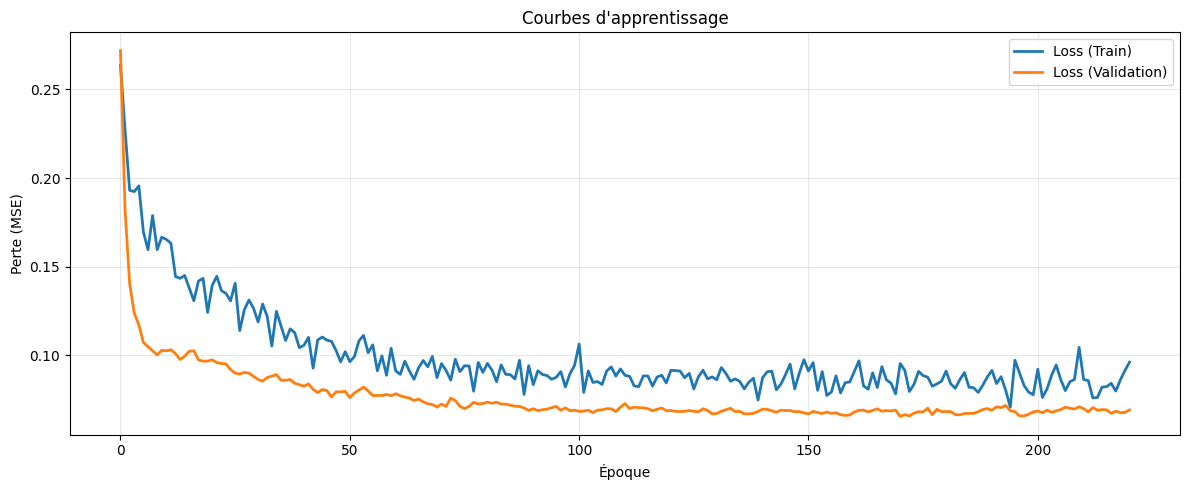

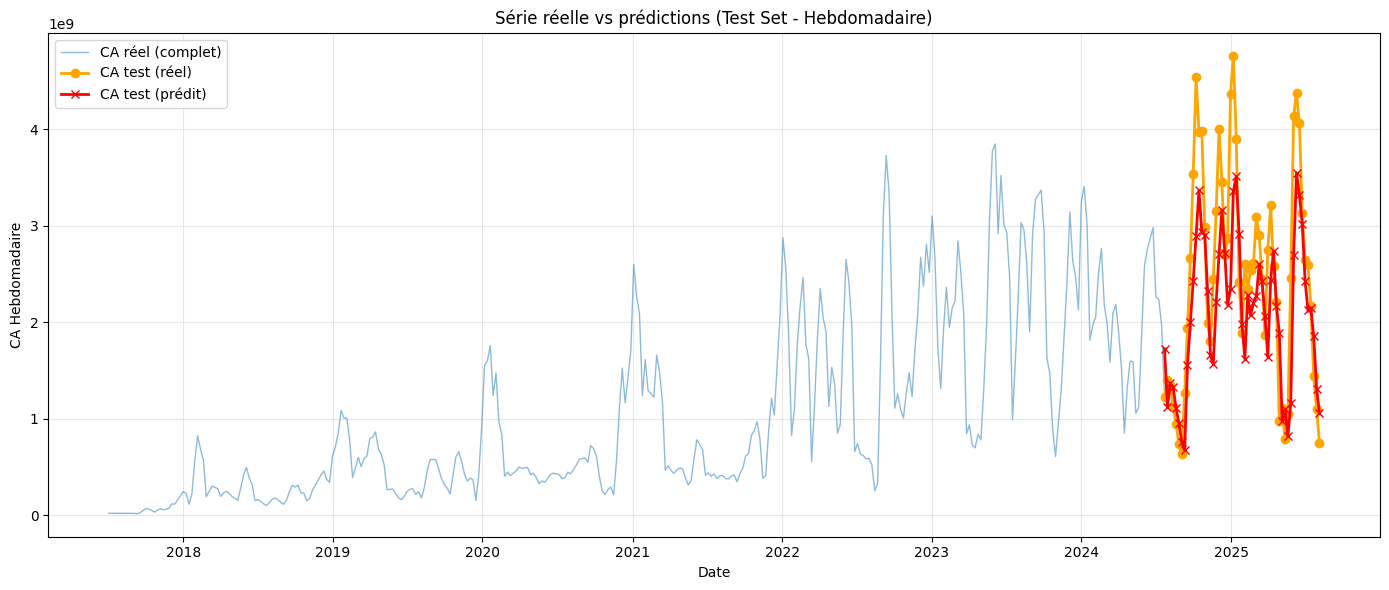

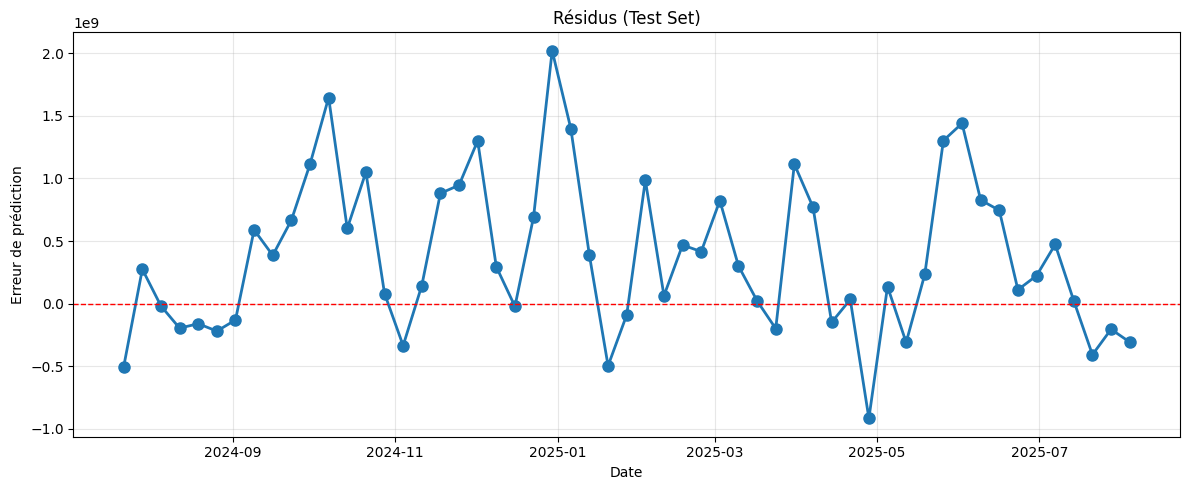

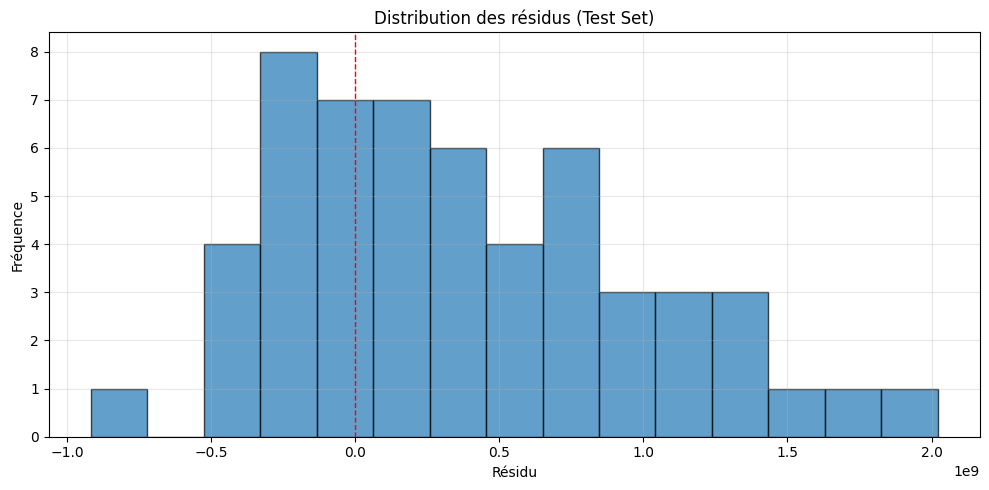

In [74]:
# 9. Visualisations et diagnostics

# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Loss (Train)', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Loss (Validation)', linewidth=2)
plt.title('Courbes d\'apprentissage')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Série réelle vs prédictions (test)
if use_validation:
    test_dates = df_monthly.index[seq_len+len(X_train)+len(X_val):seq_len+len(X_train)+len(X_val)+len(y_test)]
else:
    test_dates = df_monthly.index[seq_len+len(X_train):seq_len+len(X_train)+len(y_test)]

plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly['CA_SEMAINE'], label='CA réel (complet)', alpha=0.5, linewidth=1)
plt.plot(test_dates, y_test_real, 'o-', label='CA test (réel)', markersize=6, linewidth=2, color='orange')
plt.plot(test_dates, y_pred_test, 'x-', label='CA test (prédit)', markersize=6, linewidth=2, color='red')
plt.xlabel('Date')
plt.ylabel('CA Hebdomadaire')
plt.title('Série réelle vs prédictions (Test Set - Hebdomadaire)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Résidus
residuals = y_test_real - y_pred_test
plt.figure(figsize=(12, 5))
plt.plot(test_dates, residuals, marker='o', linewidth=2, markersize=8)
plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.title('Résidus (Test Set)')
plt.xlabel('Date')
plt.ylabel('Erreur de prédiction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution des résidus
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7)
plt.axvline(0, color='r', linestyle='--', linewidth=1)
plt.title('Distribution des résidus (Test Set)')
plt.xlabel('Résidu')
plt.ylabel('Fréquence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

